# Asymmetric Information Costs (AIC) in Market Microstructure

This notebook explores an example for understanding intraday stock price variations. The following example also helps to explain factors that determine variables such as the order flow and the bid-ask spread. 

It also an experiment about how price volatility, spreads, and order flow are interrelated. The discussions cover price dynamics and the Efficient Market Hypothesis (EMH); including (1) informative order flow and (2) price discovery.

## Context

When investors trade on their private knowledge, their orders convey information to the rest of the market, over and above what is already publicly available. In this environment, market participants will revise their estimate of securities' values in light of the order flow: unusual buying pressure will induce price increases; unusual selling pressure, price declines.

This feature can explain the existence of a __bid-ask spread__. In principle, dealers are not always as well informed as each and every customer. Traders with superior information will exploit any mispricing by dealers, buying when the ask price is lower than the fundamental value and selling when the bid price is higher. Dealers lose money when they trade with such investors. This is known as "__adverse selection__": due to the informational asymmetry, market makers tend to attract customers who expect to make a profit at the dealer's expense. To recoup their losses on informed orders, dealers must gain on their business with other traders (typically, liquidity/noise traders). They achieve this by means of the bid-ask spread vis-à-vis all customers.

To investiguate this idea, we will focus on Glosten and Milgrom (1985). In this model the ask price exceeds the bid because the former is set in anticipation of receiving a buy order, the latter a sell order:

\begin{align}
    a_t &= \mathbb{E}\left[ v | \Omega_{t-1}, d_t = +1 \right] \\
    b_t &= \mathbb{E}\left[ v | \Omega_{t-1}, d_t = -1 \right]
\end{align}

where, $\Omega_{t-1}$ is the information set at $t-1$, i.e., known right up to the last trade $d_t$ with $d_t = +1$ representing a buy order direction and $d_t = -1$ representing a sell order direction.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config InlineBackend.rc = {'figure.figsize': (12., 6.)}
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Glosten and Milgrom (1985) sequential model

The purpose of this exercise is to simulate the evolution of trading prices, spread sizes and pricing errors in a multi-period version of the Glosten and Milgrom (1985) model of price formation in presence of asymmetric information.

The starting values for the various underlying parameters of the model are set as follows:
* 100 periods
* $\pi = 0.3$
* $\theta_0 = 0.5$
* $v^H = 102$
* $v^L = 98$

In [2]:
periods = 100
pi = 0.3
theta_0 = 0.5
vh = 102
vl = 98

It is assumed that the true value of the stock is equal to $v^H$ and that uninformed traders buy and sell with equal probability. Trades are for 1 share only. 

For each round of trading:
1. Compute the prior probability the market maker assigns to the fact that the true value of the asset is $v^H$ and her quoted spread.
2. Generate the arrival of a trader, which will be informed or uniformed with the appropriate probability.
3. Compute the trading decision of the trader, i.e. B(uy) or S(ale), in accordance with her type, and the corresponding trading price.
4. Repeat steps 1 to 3 100 times

### Resolution

#### First bid and ask prices in the trading day
Dealer's initial estimate of $v$, the true value of the asset, is its __unconditional mean__ $\mu_0$:

$$ \mu_0 = \frac{v^H+v^L}{2} $$

So:

In [3]:
vu = (vh + vl) / 2
vu

100.0

### Step-by-step protocol

One can also express $\theta_t = \mathbb{P}[v=v^H | \Omega_t]$. As it is $0.5$ here, the abovementionned definition holds. Otherwise, we should have computed
$$ \mu_0 = \theta_0 \times v^H + (1 - \theta_0) \times v^L. $$

As we know, bid and ask prices equal their estimate of the security's value _conditional_ on a buy or sell order.

Hence,

\begin{align*}
    \begin{cases}
        a_t = \mu^+ \equiv \mathbb{E}[v|\Omega_{t-1},q_t>0] \\
        b_t = \mu^- \equiv \mathbb{E}\left[v|\Omega_{t-1},q_t<0\right] \\
    \end{cases}
\end{align*}

Ask price at $t=1$:

\begin{align*}
a_1  &= \mu_0 + \pi \left(v^H - \mu_0\right) \\
&= \mu_0 + \frac{\pi}{2} (v^H - v^L)
\end{align*}

With the ask-side half spread equal to:
$$ s^a_1 = \frac{\pi}{2} (v^H - v^L) $$
So, $a_1$ writes down:
$$ a_1 = \mu_0 + s^a_1 $$

Thus, the equation generalizes to:

\begin{align*}
    a_t  &= \mu_{t-1} + \frac{\pi}{2} (v^H - v^L) \\
    &= \theta_{t-1} \times v^H + (1 - \theta_{t-1}) \times v^L + \frac{\pi}{2} (v^H - v^L).
\end{align*}

In [4]:
mu_0 = theta_0 * vh + (1 - theta_0) * vl
mu_0

100.0

\begin{align}
    s_t^a = \frac{\pi\theta_{t-1}(1-\theta_{t-1})}{\pi\theta_{t-1}+(1-\pi)/2}(v^H-v^L).
\end{align}

In [5]:
sa_1 = (pi * theta_0 * (1 - theta_0))/(pi * theta_0 + (1 - pi) / 2) * (vh - vl)
sa_1

0.6

\begin{align}
    s_t^b = \frac{\pi\theta_{t-1}(1-\theta_{t-1})}{\pi (1-\theta_{t-1})+(1-\pi)/2}(v^H-v^L). 
\end{align}

In [6]:
sb_1 = (pi * theta_0 * (1 - theta_0))/(pi * (1 - theta_0) + (1 - pi) / 2) * (vh - vl)
sb_1

0.6

In [7]:
a_1 = mu_0 + sa_1
b_1 = mu_0 - sb_1
print(a_1, b_1)

100.6 99.4


$$ \text{Spread size} = \frac{a_t - b_t}{\left(\frac{a_t + b_t}{2}\right)}: $$

In [8]:
# spread (relative) size
s_1 = (a_1 - b_1) / np.mean([a_1, b_1])
print(f"The relative spread size is: {s_1:.3f}")

The relative spread size is: 0.012


In [9]:
def generate_arrivals(periods, pi):
    trader_types = (np.random.uniform(0.0, 1.0, periods) > pi).astype(int)
    trader_types[trader_types == 0] = -1
    return trader_types

In [10]:
trader_types = generate_arrivals(periods, pi)
trader_types

array([ 1, -1,  1, -1,  1, -1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,
       -1,  1,  1,  1, -1,  1,  1,  1,  1, -1, -1,  1, -1, -1,  1,  1,  1,
       -1, -1, -1, -1,  1, -1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1,
        1,  1, -1, -1, -1,  1, -1,  1,  1,  1, -1, -1, -1,  1, -1])

In [11]:
p_1 = a_1 if trader_types[0] == 1 else b_1
p_1

100.6

According to the orders that materialize, dealers revise their beliefs of what the true price value of the security should be. Here, we will apply the _update rule_ of $\theta$ using Baye's rule.

* Denote $A$ the event $v=v^L$ and $B$ tge arrival of a buy order at time $t$.
* We want to calculate $\mathbb{P}(A|B)$.
* From Baye's Rule:
\begin{align}
    \mathbb{P}(A|B)
    &= \frac{\mathbb{P}(A \cap B)}{\mathbb{P}(B)} \\
    &= \frac{\mathbb{P}(B|A)\mathbb{P}(A)}{\mathbb{P}(B)}.
\end{align}

Therefore, if a buy order arrives: $ \theta_t^+ = \mathbb{P}\left[ v = v^L | \Omega_{t-1},Buy \right] $

\begin{align}
    \theta_t^+ 
    &= \frac{P(Buy|v^L)P(v^L | \Omega_{t-1})}{P(Buy)}  \\
    &= \frac{(1+\pi)\frac{1}{2}\theta_{t-1}}{\pi \theta_{t-1} + (1-\pi)\frac{1}{2}}
\end{align}

In [12]:
def theta_plus(theta_lag, pi, trade_type):
    return ((1 + pi) / 2 * theta_lag) / ((1 - pi) / 2 + pi * theta_lag)

The belief in case a sell order arrives summarizes to the expression: $ \theta_t^- = \mathbb{P}\left[ v = v^H | \Omega_{t-1},Sell \right] $

\begin{align}
    \theta_t^- = \frac{(1-\pi)\frac{1}{2}\theta_{t-1}}{\pi(1-\theta_{t-1}) + (1-\pi)\frac{1}{2}}
\end{align}

In [13]:
def theta_minus(theta_lag, pi, trade_type):
    return ((1 - pi) / 2 * theta_lag) / ((1 - pi) / 2 + pi * (1 - theta_lag))

In [14]:
theta_1 = theta_minus(theta_0, pi, trader_types[0]) if trader_types[0] == -1 else theta_plus(theta_0, pi, trader_types[0])
theta_1

0.65

$$ \text{Pricing error} = |v^H - \mu_t| $$

In [15]:
# pricing error
print(f"The pricing error in the first period is: {np.abs(p_1 - mu_0):.3f}")

The pricing error in the first period is: 0.600


## The whole model

In [16]:
def generate_sequential_model(periods, pi, theta_0, vh, vl):
    theta_lag = []
    theta = []
    mu_lag = []
    sb = []
    sa = []
    b = []
    a = []
    price = []
    spread = []  # relative spread size
    error = []
    
    trader_types = generate_arrivals(periods, pi)
    
    for i in range(periods):
        if i == 0:
            theta_lag.append(theta_0)
            
            mu_0 = theta_0 * vh + (1 - theta_0) * vl
            mu_lag.append(mu_0)
        else:
            theta_lag.append(theta[i-1])
            mu_lag_t1 = theta_lag[i] * vh + (1 - theta_lag[i]) * vl
            mu_lag.append(mu_lag_t1)
        
        sa_t = ((pi * theta_lag[i] * (1 - theta_lag[i])) / (pi * theta_lag[i] + ((1 - pi) / 2))) * (vh - vl)
        sa.append(sa_t)
        
        sb_t = ((pi * theta_lag[i] * (1 - theta_lag[i])) / (pi * (1 - theta_lag[i]) + ((1 - pi) / 2))) * (vh - vl)
        sb.append(sb_t)
        
        a_t = mu_lag[i] + sa_t
        a.append(a_t)
        
        b_t = mu_lag[i] - sb_t
        b.append(b_t)
        
        price_t = a_t if trader_types[i] == 1 else b_t
        price.append(price_t)
        
        theta_t = theta_minus(theta_lag[i], pi, trader_types[i]) if trader_types[i] == -1 else theta_plus(theta_lag[i], pi, trader_types[i])
        theta.append(theta_t)
        
        spread_t = (a_t - b_t)/np.mean([a_t, b_t])
        spread.append(spread_t)
        
        pricing_error = np.abs(price_t - mu_lag[i])
        error.append(pricing_error)
    
    data = [theta_lag, mu_lag, sb, sa, b, a, trader_types, price, theta, spread, error]
    columns = ['theta_{t-1}', 'mu_{t-1}', 'Sb_t', 'Sa_t', 'Bid_t', 'Ask_t', 
               'Trader type', 'Price', 'theta_t', 'Relative spread size', 'Pricing error']
    df = pd.DataFrame(data=data).T
    df.columns = columns
    df.index = np.arange(1, periods + 1)
    df.index.name = 'Round'
    return df       

In [17]:
model1 = generate_sequential_model(periods, pi, theta_0, vh, vl)
model1.head()

,theta_{t-1},mu_{t-1},Sb_t,Sa_t,Bid_t,Ask_t,Trader type,Price,theta_t,Relative spread size,Pricing error
Round,,,,,,,,,,,
1,0.50,100.0,0.600000,0.600000,99.400000,100.600000,1.0,100.6,0.65,0.012000,0.6
2,0.65,100.6,0.600000,0.500917,100.000000,101.100917,-1.0,100.0,0.50,0.010949,0.6
3,0.50,100.0,0.600000,0.600000,99.400000,100.600000,-1.0,99.4,0.35,0.012000,0.6
4,0.35,99.4,0.500917,0.600000,98.899083,100.000000,1.0,100.0,0.50,0.011070,0.6
5,0.50,100.0,0.600000,0.600000,99.400000,100.600000,1.0,100.6,0.65,0.012000,0.6


In [18]:
def subplots_(model, figsize=(11, 5)):
    fig, axs = plt.subplots(ncols=2, figsize=figsize)
    ax1, ax2 = axs
    ax1.plot(model[['Relative spread size']], color='blue')
    ax1.grid(True, alpha=0.5)
    ax1.set_title('Relative spread size')
    ax2.plot(model[['Pricing error']], color='red')
    ax2.set_title('Pricing error')
    ax2.grid(True, alpha=0.5)
    plt.show()

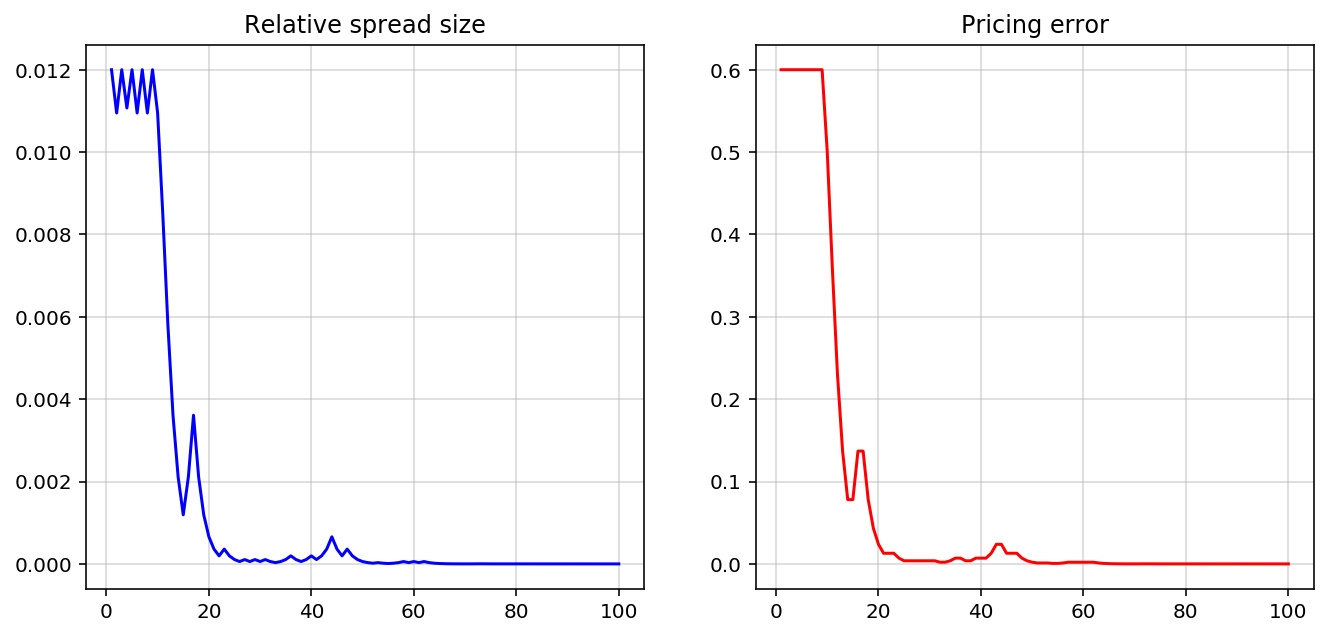

In [19]:
subplots_(model1)

## Question 1: How do spread size and pricing errors evolve over time?

The __spread size__ in left plot (above) decreases with time since uncertainty is very high at the very beginning. This is why the spread is the higher at the beginning of the period.

NB: Moreover, liquidity changes systematically in a much more limited time frame as well: within a single trading day, bid-ask spreads tend to feature a __U-shaped pattern__, higher at the open and at the close than during the rest of the trading day. So, we see here that we capture the uncertainty of the beginning but not the one related to the close.

The __pricing error__ exhibited in above right plot also attests for the __learning process__. Indeed, after a certain time, the dealer is able to extract the true value of the stock. We see that after some time, the dealer discovers the true value of the security.

We will study the speed of convergence to the true price, or price discovery speed, conditional to the number of informed traders playing in the market in later questions. That is, by setting different values for $\pi$.

## Question 2: Redo the simulations assuming that informed traders have a higher informational advantage. What do you observe?

The informational advantage is the range of variation of $v$, i.e., $\left( v^H - v^L \right)$.

Consider the (first) bid-ask spread at $t=1$:

\begin{align}
    S_1 &= a_1 - b_1 \\
        &= s^a_1 - s^b_1 \\
        &= \frac{\pi}{2} \left( v^H - v^L \right) + \frac{\pi}{2} \left( v^H - v^L \right) \\
        &= \pi \left( v^H - v^L \right)
\end{align}

* $\pi$ is interpreted as the proportion of informed traders (the higher $\pi$, the more informed traders)
* $\left( v^H - v^L \right)$ is the informational advantage of informed traders

So, what happens if $\pi$ increases?
* We should see that the price discovery fastens as there is much less noise in the market

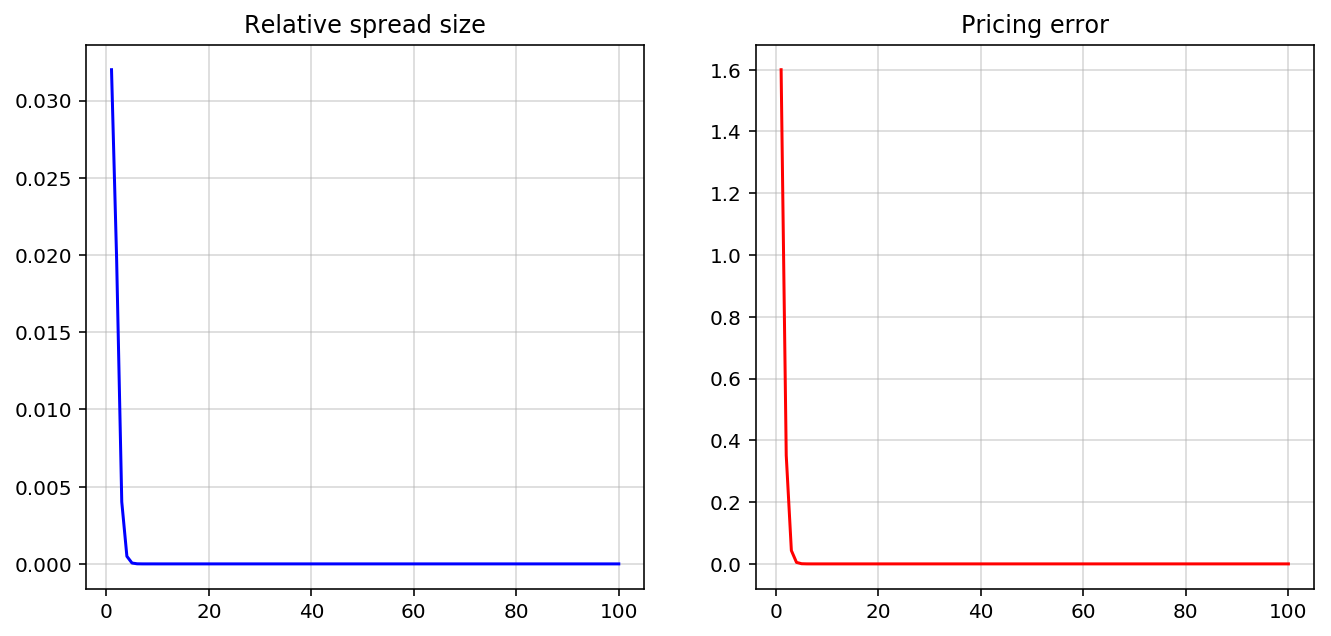

In [20]:
model2 = generate_sequential_model(periods, 0.8, theta_0, vh, vl)
subplots_(model2)

## Question 3: Redo the simulations assuming that the market makers faces:
1. higher adverse selection risk
2. lower adverse selection risk

What do you observe?

So, here, we have to play around the $\left( v^H - v^L \right)$ argument (the informational advantage of informed traders). If adverse selection is high, the range would be wide.

* The more adverse selection, the wider the spread at the beginning
* No real effect on the price discovery process

Remember that, overall, the models we will see in these course (Glosten-Milgrom included) present three kinds of __cost__ for __liquidity suppliers__: 
1. __the cost of trading with better informed investors (adverse selection costs)__, 
1. the real cost of processing orders (order processing costs), and
1. the cost of holding risky assets (inventory holding costs).

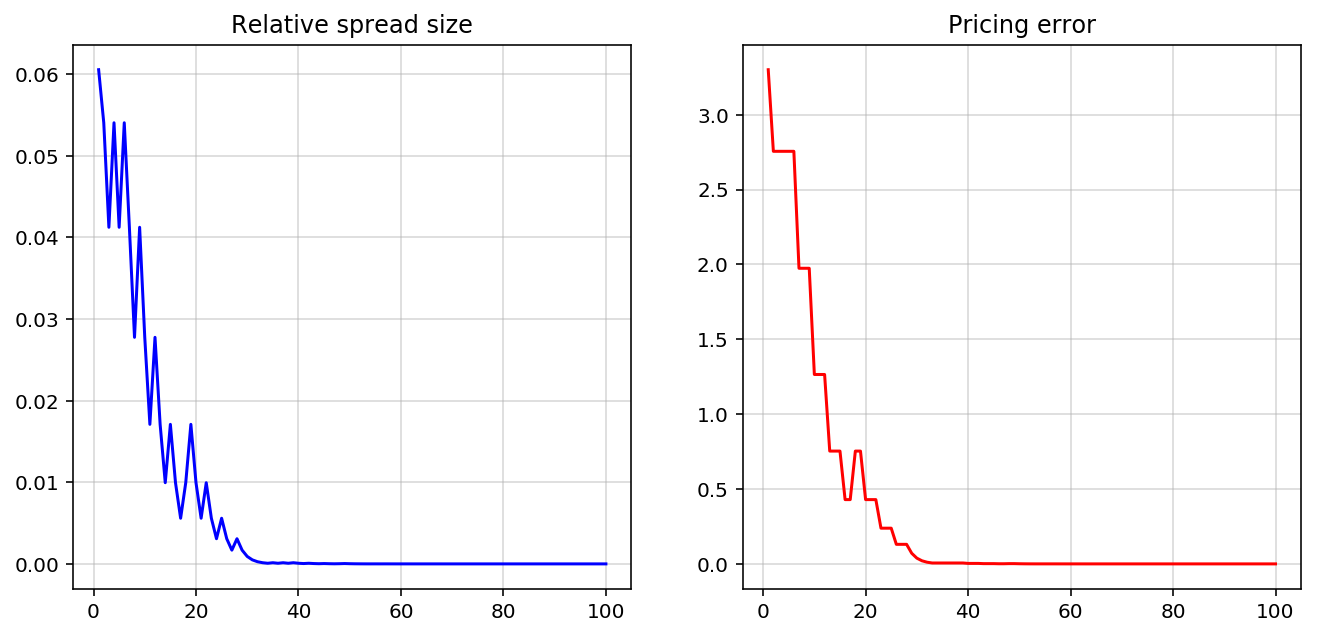

In [21]:
model3 = generate_sequential_model(periods, 0.3, theta_0, 120, vl)
subplots_(model3)